In [106]:
import json
import piezo
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.image as mpimg
from protocols import utils
from catomatic.CatalogueBuilder import BuildCatalogue
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from protocols.predict_2 import piezo_predict
from scipy.stats import pearsonr

This notebook runs through the data preperation used in the study, and demonstrates the software that builds the catalogues and how we use them to make predictions.

The logic behind the algorithm is explored in detail in `supplement.ipynb`

# Import the source data from CRyPTIC and NICD

All these data tables were extracted from the CRyPTIC tables v2.1.1. To save space, the MUTATIONS table has been subsetted down to only include mutations in mmpL5, pepQ, Rv0678, atpE and mmpS5. CRyPTIC v2.1.1 was created on 20 March 2024.

In [107]:
#read in cyrptic samples
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz", index_col=0)
phenotypes_cryptic_samples = set(phenotypes_cryptic.index)
#read in new nicd samples
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz", index_col=0)
phenotypes_nicd_samples = set(phenotypes_nicd.index)
#read in the mutations tables, subsetted down to BDQ WHO-defined candidate genes
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz', index_col=0)
#GARC mutation naming
mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
#flag sysnonymous mutations
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)
#read in table of genomes
genomes = pd.read_csv("./data/GENOMES.csv.gz", index_col=0)
#read in growth data of the cryptic plates
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

In [108]:

print(f"The CRyPTIC project has {phenotypes_cryptic.index.nunique()} unique isolates with a BDQ DST measurement\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]

print(f"Subsetting down to only those samples which were innoculated onto an UKMYC plate reduces the number to {phenotypes_cryptic.index.nunique()}.\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']

print(f"Accepting those where more than one method agree on the MIC leaves {phenotypes_cryptic.index.nunique()} samples.\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.index.isin(genomes.index)]

print(f"..and of those only {phenotypes_cryptic.index.nunique()} samples also underwent WGS.")

assert phenotypes_cryptic.index.nunique() == len(phenotypes_cryptic.index), 'one or more samples have more than one DST measurement!'

The CRyPTIC project has 21178 unique isolates with a BDQ DST measurement

Subsetting down to only those samples which were innoculated onto an UKMYC plate reduces the number to 21057.

Accepting those where more than one method agree on the MIC leaves 14605 samples.

..and of those only 10704 samples also underwent WGS.


If we look at the final group of samples which (i) went on an UKMYC plate, (ii) had two or more methods agree on the MIC and (iii) underwent WGS

In [109]:
pd.crosstab(phenotypes_cryptic.METHOD_3, phenotypes_cryptic.PHENOTYPE, margins=True)

PHENOTYPE,R,S,All
METHOD_3,,,
UKMYC5,29,4387,4416
UKMYC6,54,6234,6288
All,83,10621,10704


In [110]:
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].index

phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.index.isin(has_mgit)]

print(f"The NICD dataset has {phenotypes_nicd.index.nunique()} unique isolates with a BDQ MGIT960 DST measurement\n")

phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.index.isin(genomes.index)]

print(f".. and of those {phenotypes_nicd.index.nunique()} also underwent WGS ..\n")

print(f".. of these {phenotypes_nicd[(phenotypes_nicd.PHENOTYPE=='R')].index.nunique()} are resistant to BDQ according at least one method\n")

# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd.reset_index(inplace=True)
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)
phenotypes_nicd.reset_index(drop=True, inplace=True)
phenotypes_nicd.set_index('UNIQUEID',inplace=True)

The NICD dataset has 1168 unique isolates with a BDQ MGIT960 DST measurement

.. and of those 1163 also underwent WGS ..

.. of these 783 are resistant to BDQ according at least one method



Now we can look at how these are split between the DST methods



In [111]:
pd.crosstab(phenotypes_nicd.PHENOTYPE, phenotypes_nicd.METHOD_CC, margins=True)     

METHOD_CC,1.0,WHO,All
PHENOTYPE,,,
R,472,311,783
S,139,241,380
All,611,552,1163


In [112]:
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"

phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 

assert phenotypes.index.nunique() == len(phenotypes.index), 'one or more samples have more than one DST measurement!'

print(f"The combined dataset has {len(phenotypes)} samples with a BDQ DST result and WGS data")

The combined dataset has 11867 samples with a BDQ DST result and WGS data


In [113]:
pd.crosstab(phenotypes.PHENOTYPE, phenotypes.METHOD_3, margins=True)

METHOD_3,MGIT960,UKMYC5,UKMYC6,All
PHENOTYPE,,,,
R,783,29,54,866
S,380,4387,6234,11001
All,1163,4416,6288,11867


# Data prep for catalogue building

In [114]:
# Filter out synonymous mutations
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()

# Merge genomes and phenotypes tables
samples = phenotypes.join(genomes, how="inner")[["DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]]

with open('./wildcards/bdq_wildcards.json') as f:
    piezo_wildcards = json.load(f)

We use high quality phenotypes due to low signal in CRypTIC 1, and therefore good chance of FP. So get rid of them.

# Basic Numbers (at FRS 0.75)

## Non-wt samples - used to build catalogues

In [115]:
all_cat = cat_mutations.join(samples, how='inner')
all_cat.reset_index(inplace=True)
utils.combined_data_table((all_cat[all_cat.FRS>=0.75]))

All               Minor alleles             All                \
          R      S  Total             R   S Total     R      S  Total   
Total   860  10897  11757            62  57   119  2151  21465  23616   
Rv0678  533    364    897            57  19    76   554    374    928   
mmpL5   859  10895  11754             5  36    41  1572  20638  22210   
pepQ     13    150    163             1   2     3    13    361    374   
mmpS5     1     56     57             0   0     0     1     59     60   
atpE     11     14     25             3   1     4    11     33     44   

       Minor alleles            
                   R   S Total  
Total             67  66   133  
Rv0678            57  19    76  
mmpL5              6  44    50  
pepQ               1   2     3  
mmpS5              0   0     0  
atpE               3   1     4

Nearly all non-wt samples contain an mmpL5 non-synonymous variants - this corresponds to 22210 total mutations in mmpL5

## All samples - used to test catalogues (include wt and synonymous)


In [116]:
all = mutations.join(samples, how='right')
all['GENE'].fillna('None', inplace=True)
all.reset_index(inplace=True)
utils.combined_data_table((all[all.FRS>=0.25]))

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   861  10906  11767           239  245   484  2463  22747  25210   
Rv0678  689    431   1120           225   74   299   805    474   1279   
mmpL5   860  10901  11761             7  133   140  1620  21342  22962   
pepQ     20    255    275             8   46    54    22    679    701   
mmpS5     4     79     83             2    2     4     4     83     87   
atpE     12     30     42             3    6     9    12    169    181   

       Minor alleles             
                   R    S Total  
Total            332  441   773  
Rv0678           307   95   402  
mmpL5             10  187   197  
pepQ              10   47    57  
mmpS5              2    2     4  
atpE               3  110   113

# Catalogue Construction

As detailed in `supplement.ipynb` we have developed a method to algorithmically catalogue BDQ variants using a two tailed binomial test against a 10% background rate, under the null hypothesis that for that particular variant there is no statistical difference between theh proportion of resistance for samples that contain only that mutation, and the supplied background rate of 10%.

This has been implemented via a flexbile catalogue construction tool we have developed, called `catomatic`, which allows to us to easily vary test parameters and observe their effect.

In [117]:
#remove mmpL5 and mmpS5 as no evidence of resistance
_cat_mutations = cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])]

_cat_mutations.reset_index(inplace=True)
samples.reset_index(inplace=True)

catalogue = BuildCatalogue(
    samples=samples,
    mutations=_cat_mutations,
    FRS=0.1,
    test='Binomial',
    background=0.1,
    tails='two',
    strict_unlock=True,
)
catalogue.return_catalogue()

{'Rv0678@A101E': {'pred': 'U',
  'evid': ({'proportion': 0.0,
    'confidence': (0.0, 0.7934506856227626),
    'p_value': 1.0,
    'contingency': [[0, 1], [136, 10372]]},)},
 'Rv0678@S68N': {'pred': 'U',
  'evid': ({'proportion': 1.0,
    'confidence': (0.20654931437723742, 1.0),
    'p_value': 0.1,
    'contingency': [[1, 0], [136, 10372]]},)},
 'Rv0678@Q51R': {'pred': 'U',
  'evid': ({'proportion': 0.3333333333333333,
    'confidence': (0.061491944720396215, 0.7923403991979523),
    'p_value': 0.271,
    'contingency': [[1, 2], [136, 10372]]},)},
 'Rv0678@G103S': {'pred': 'U',
  'evid': ({'proportion': 0.0,
    'confidence': (0.0, 0.6576197724933469),
    'p_value': 1.0,
    'contingency': [[0, 2], [136, 10372]]},)},
 'Rv0678@A62T': {'pred': 'U',
  'evid': ({'proportion': 0.0,
    'confidence': (0.0, 0.7934506856227626),
    'p_value': 1.0,
    'contingency': [[0, 1], [136, 10372]]},)},
 'Rv0678@192_ins_g': {'pred': 'R',
  'evid': ({'proportion': 0.4230769230769231,
    'confidence':

This can then be returned in a piezo-format dataframe:

In [118]:
catalogue.build_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards,)

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
313,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,Rv0678@*=,S,{},"{""default_rule"": ""True""}",{}
319,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,pepQ@*=,S,{},"{""default_rule"": ""True""}",{}
325,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,mmpS5@*=,S,{},"{""default_rule"": ""True""}",{}
331,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,mmpL5@*=,S,{},"{""default_rule"": ""True""}",{}
337,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@*=,S,{},"{""default_rule"": ""True""}",{}
...,...,...,...,...,...,...,...,...,...,...,...
338,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,{},"{""default_rule"": ""True""}",{}
339,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,{},"{""default_rule"": ""True""}",{}
340,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@-*?,U,{},"{""default_rule"": ""True""}",{}
341,NC_000962.3,BDQ-FRS-75-2024.06,1.1,GARC1,RUS,BDQ,atpE@*?,U,{},"{""default_rule"": ""True""}",{}


Which can then be manipulated or examined using standard pandas operations (note, this will include the wildcard and seeded rows):

In [119]:
catalogue.build_piezo("NC_000962.3", f"BDQ-FRS-75-2024.06", "1.1", "BDQ", piezo_wildcards,)['PREDICTION'].value_counts()

U    267
R     71
S      5
Name: PREDICTION, dtype: int64

From a csv file of the dataframe, we can make sample-level predictions via the following protocol:


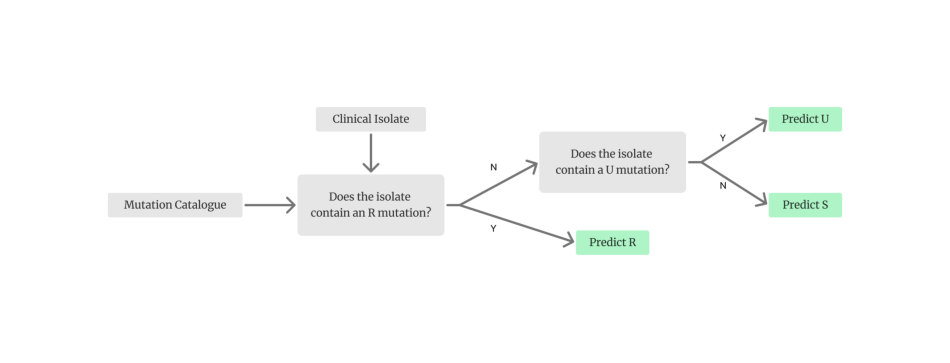

In [120]:
img = mpimg.imread('./imgs/manuscript_2/predict_protocol.png')
plt.figure(figsize=(12, 8)) 
plt.imshow(img)
plt.axis('off')  
plt.show()

Under the hood, piezo parses the catalogues and makes the sample predictions. Wildcards are supplied to the catalogue to provide default classification rules for piezo, in the absence of any rows for that mutation.

Note, in results 2 versions of this are explored; one where U samples are assumed to be S (binary system) and this one where U's are reported seperately, and an additional performance metric is introduced, sample coverage (tertiary system).

[[  607   135   124]
 [  172 10370   459]]
Catalogue coverage of isolates: 0.9508721665121767
Sensitivity: 0.8180592991913747
Specificity: 0.9836843103775375


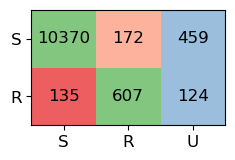

In [121]:
#make predictions to calculate sensitivity and coverage

#remove mmpL5 and mmpS5 from test set (under the assumption they are benign)
all_ = pd.merge(samples, cat_mutations[~cat_mutations.GENE.isin(['mmpL5', 'mmpS5'])],  how='left', on='UNIQUEID')

cm, _cov, _sens, _spec, _FN_ids = piezo_predict(all_ , './catalogues/temp/binomial_2_tailed.csv', "BDQ", Print=True, U_to_S=False)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

utils.plot_truthtables(df_cm)